In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define paths
DATA_PATH = "/content/drive/MyDrive/Modelo_Taxonomico/Class"
TRAIN_PATH = os.path.join(DATA_PATH, "train")
VAL_PATH = os.path.join(DATA_PATH, "val")
TEST_PATH = os.path.join(DATA_PATH, "test")
# Define Class
csv_file = '/content/drive/MyDrive/Modelo_Taxonomico/CSV/data_def.csv'
df = pd.read_csv(csv_file)
classes = df['class'].unique().tolist()
# Define image size
SIZE=224
IM_SIZE = (224, 224, 3)
# Define batch size
BATCH_SIZE = 8

In [ ]:
print(classes)

['EM', 'BI', 'TM', 'GE', 'VI', 'S', 'MH']


In [ ]:
# Create data generators
valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    fill_mode="nearest",
)

train_batches = train_datagen.flow_from_directory(
    TRAIN_PATH,
    classes=classes,
    target_size=IM_SIZE[:2],
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE,
)

valid_batches = valid_datagen.flow_from_directory(
    VAL_PATH,
    classes=classes,
    target_size=IM_SIZE[:2],
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

test_batches = test_datagen.flow_from_directory(
    TEST_PATH,
    classes=classes,
    target_size=IM_SIZE[:2],
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

Found 13374 images belonging to 7 classes.
Found 1670 images belonging to 7 classes.
Found 1680 images belonging to 7 classes.


## Finetuning B3 EfficientNet

https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#transfer-learning-from-pretrained-weights

In [ ]:
def build_model(num_classes):
    base_model = EfficientNetB3(
        include_top=False, weights="imagenet", input_tensor=None, input_shape=IM_SIZE
    )
    x = base_model.output
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation="softmax", name="softmax")(x)
    model = Model(inputs=base_model.input, outputs=output_layer)
    model.compile(
        optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [ ]:
# Estimate class weights for unbalanced dataset
class_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(train_batches.classes), y=train_batches.classes
)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
# ModelCheckpoint callback
ModelCheck = ModelCheckpoint(
    "/content/drive/MyDrive/Modelo_Taxonomico/Modelo/Weight/Optimizador_efficientnet_b3_tuned.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    save_freq='epoch',
)

In [ ]:
# ReduceLR callback
ReduceLR = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=5, min_lr=3e-4
)

In [ ]:
# EarlyStopping callback
EarlyStop = EarlyStopping(
    monitor="val_loss", patience=10, verbose=1, mode="auto"
)

In [ ]:
print("Train Path:", TRAIN_PATH)
print("Validation Path:", VAL_PATH)
print("Test Path:", TEST_PATH)

Train Path: /content/drive/MyDrive/Modelo_Taxonomico/Class/train
Validation Path: /content/drive/MyDrive/Modelo_Taxonomico/Class/val
Test Path: /content/drive/MyDrive/Modelo_Taxonomico/Class/test


In [ ]:
print(df.head())

              name class
0  71529-4-0-0.png    EM
1  71529-4-1-0.png    EM
2  71529-4-0-2.png    EM
3  71529-4-0-1.png    EM
4  71529-4-1-1.png    EM


In [ ]:
# Validación cruzada k-fold
num_folds = 5
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [ ]:
for fold, (train_index, val_index) in enumerate(kf.split(df['name'], df['class'])):
    print(f"Fold {fold + 1}/{num_folds}")

    # Reduzcamos la carga solo para probar la estructura
    train_data, val_data = df.iloc[train_index[:int(len(train_index)*0.01)]], df.iloc[val_index[:int(len(val_index)*0.01)]]

    train_batches = train_datagen.flow_from_directory(
        TRAIN_PATH,
        classes=classes,
        target_size=IM_SIZE[:2],
        class_mode="categorical",
        shuffle=True,
        batch_size=BATCH_SIZE,
    )

    valid_batches = valid_datagen.flow_from_directory(
        VAL_PATH,
        classes=classes,
        target_size=IM_SIZE[:2],
        class_mode="categorical",
        shuffle=False,
        batch_size=BATCH_SIZE,
    )

Fold 1/5
Found 13374 images belonging to 7 classes.
Found 1670 images belonging to 7 classes.
Fold 2/5
Found 13374 images belonging to 7 classes.
Found 1670 images belonging to 7 classes.
Fold 3/5
Found 13374 images belonging to 7 classes.
Found 1670 images belonging to 7 classes.
Fold 4/5
Found 13374 images belonging to 7 classes.
Found 1670 images belonging to 7 classes.
Fold 5/5
Found 13374 images belonging to 7 classes.
Found 1670 images belonging to 7 classes.


In [ ]:
# Build and compile the model outside the k-fold loop
model = build_model(num_classes=len(classes))
model.summary()

43941136/43941136 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

In [ ]:
#Train Model
history = model.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=25,
    callbacks=[ModelCheck, ReduceLR, EarlyStop],
    class_weight=class_weights_dict,
    workers=4
)

val_loss, val_accuracy = model.evaluate(valid_batches)
print(f"Validation Accuracy for Fold {fold + 1}: {val_accuracy}")

Epoch 1/25
1672/1672 [==============================] - ETA: 0s - loss: 2.5151 - accuracy: 0.5282
Epoch 1: val_loss improved from inf to 1.10391, saving model to /content/drive/MyDrive/Modelo_Taxonomico/Modelo/Weight/Optimizador_efficientnet_b7_tuned.h5
1672/1672 [==============================] - 1605s 957ms/step - loss: 2.5151 - accuracy: 0.5282 - val_loss: 1.1039 - val_accuracy: 0.6515 - lr: 0.0010
Epoch 2/25
1672/1672 [==============================] - ETA: 0s - loss: 1.7659 - accuracy: 0.5861
Epoch 2: val_loss did not improve from 1.10391
1672/1672 [==============================] - 367s 219ms/step - loss: 1.7659 - accuracy: 0.5861 - val_loss: 3.0251 - val_accuracy: 0.6030 - lr: 0.0010
Epoch 3/25
1672/1672 [==============================] - ETA: 0s - loss: 1.9489 - accuracy: 0.5473
Epoch 3: val_loss did not improve from 1.10391
1672/1672 [==============================] - 379s 227ms/step - loss: 1.9489 - accuracy: 0.5473 - val_loss: 17.9526 - val_accuracy: 0.3317 - lr: 0.0010
Epoc

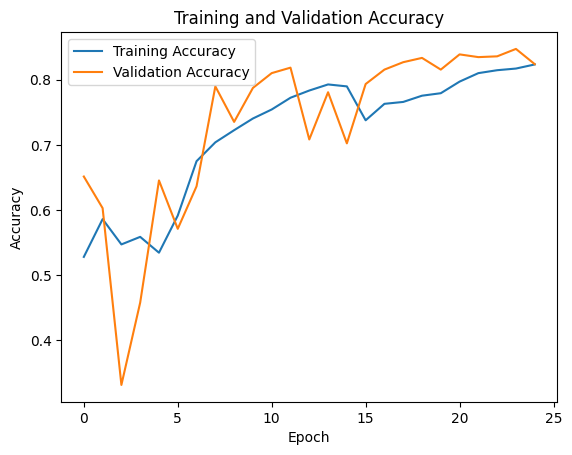

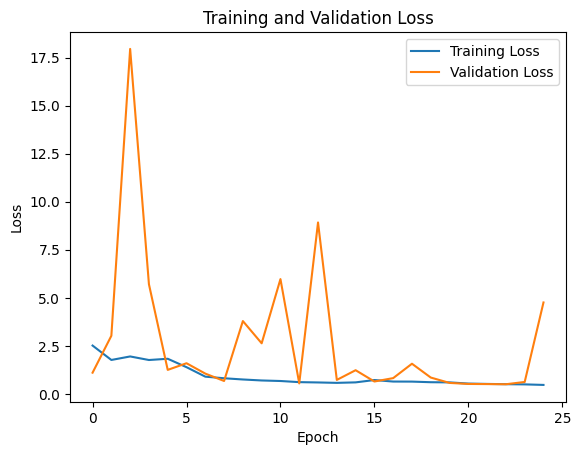

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
optimal_thresholds = []

210/210 [==============================] - 229s 1s/step
Optimal Threshold for Class EM: 0.22222222222222224
Optimal Threshold for Class BI: 0.07070707070707072
Optimal Threshold for Class TM: 0.22222222222222224
Optimal Threshold for Class GE: 0.09090909090909091
Optimal Threshold for Class VI: 0.010101010101010102
Optimal Threshold for Class S: 0.30303030303030304
Optimal Threshold for Class MH: 0.98989898989899


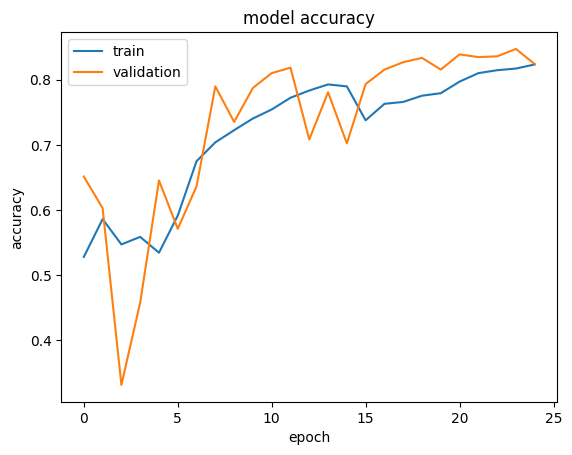

In [ ]:
# Threshold Optimization
test_predictions = model.predict(test_batches)

for i in range(len(classes)):
    true_labels = test_batches.classes == i

    best_fbeta = 0
    best_threshold = 0

    for threshold in np.linspace(0, 1, 100):
        predicted_labels = test_predictions[:, i] > threshold
        fbeta = fbeta_score(true_labels, predicted_labels, beta=2)

        if fbeta > best_fbeta:
            best_fbeta = fbeta
            best_threshold = threshold

    optimal_thresholds.append(best_threshold)
    print(f"Optimal Threshold for Class {classes[i]}: {best_threshold}")

# Plot training history
plot_hist(history)

In [ ]:
# Load weights from the file
model.load_weights("/content/drive/MyDrive/Modelo_Taxonomico/Modelo/Weight/efficientnet_b7_tuned.h5")

In [ ]:
!pip install scikit-learn seaborn

#Matriz de Confusion

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

210/210 [==============================] - 18s 84ms/step


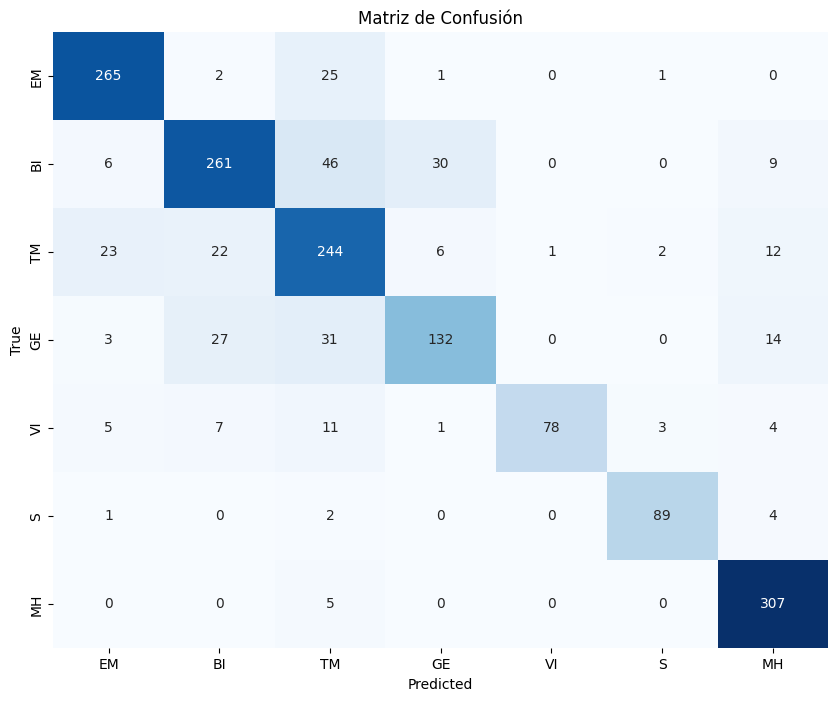


Informe de clasificación:
               precision    recall  f1-score   support

          EM       0.87      0.90      0.89       294
          BI       0.82      0.74      0.78       352
          TM       0.67      0.79      0.72       310
          GE       0.78      0.64      0.70       207
          VI       0.99      0.72      0.83       109
           S       0.94      0.93      0.93        96
          MH       0.88      0.98      0.93       312

    accuracy                           0.82      1680
   macro avg       0.85      0.81      0.83      1680
weighted avg       0.82      0.82      0.82      1680



In [ ]:
# Predecir las clases para el conjunto de prueba
y_pred = model.predict(test_batches)
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtener las clases reales
y_true = test_batches.classes

# Calcular la matriz de confusión
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Mostrar el informe de clasificación
print("\nInforme de clasificación:\n", classification_report(y_true, y_pred_classes, target_names=classes))

# Calcular nuevas metricas

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, confusion_matrix,roc_auc_score

# Extraer testing data
test_predictions_enc = model.predict(test_batches)#001,010,011,100,101..
test_predictions = np.argmax(test_predictions_enc, axis=-1)#0,1,2,3,4--> INT


# Extraer true data
test_data = []
test_labels = []
for i in range(len(test_batches)):
    batch = test_batches[i]
    test_data.append(batch[0])
    test_labels.append(batch[1])

test_data = np.concatenate(test_data)
test_labels_enc = np.concatenate(test_labels)
test_labels = np.argmax(test_labels_enc, axis=1)


210/210 [==============================] - 19s 88ms/step


In [ ]:
assert test_predictions.shape== test_labels.shape, "this should match!"

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_batches, verbose=1)
test_accuracy_percent = test_accuracy * 100

# Calculate precision, recall, and specificity (micro-averaged)
precision = precision_score(test_labels, test_predictions, average='micro')
recall = recall_score(test_labels, test_predictions, average='micro')

# Calculate true negatives, false positives, and specificity (micro-averaged)
tn = np.sum((test_labels != 1) & (test_predictions != 1))
fp = np.sum((test_labels != 1) & (test_predictions == 1))
specificity = tn / (tn + fp)

# Calculate F1 score (weighted average)
f1 = f1_score(test_labels, test_predictions, average='weighted')

# Print the evaluation metrics
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy_percent, "%")
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy_percent, "%")

print("test_predictions Shape:", test_predictions.shape)
print("test_labels Shape:", test_labels.shape)
print("F1 Score:", f1)

210/210 [==============================] - 13s 61ms/step - loss: 3.5798 - accuracy: 0.8190
Test Loss: 3.579803466796875
Test Accuracy: 81.90476298332214 %
F1 Score: 0.8175818196657307
Precision: 0.819047619047619
Recall: 0.819047619047619
Specificity: 0.9563253012048193
Test Loss: 3.579803466796875
Test Accuracy: 81.90476298332214 %
test_predictions Shape: (1680,)
test_labels Shape: (1680,)
F1 Score: 0.8175818196657307
